In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def ornstein_uhlenbeck_noise(T: int, sigma: float, rho: float):
    etas = np.random.normal(0, 1, 5 * T) * sigma  # white noise
    x = np.zeros(5 * T)
    for t in range(1, 5 * T):
        x[t] = rho * x[t - 1] + etas[t]
    return x[-T:]

In [3]:
def logistic_curve(T: int, t0: float, sigma: float, rho: float, L: float, k: float):
    # L / (1 + exp(-k * (t- t0) + noise))
    x = np.zeros(T)
    noise = ornstein_uhlenbeck_noise(T, sigma, rho)
    for t in range(T):
        x[t] = L / (1 + np.exp(-k * (t - t0) + noise[t]))
    return x

In [4]:
t0 = 50
T = 80
sigma = 0.2
rho = 0.1
L = 6
k = 0.08

x = logistic_curve(T, t0, sigma, rho, L, k)

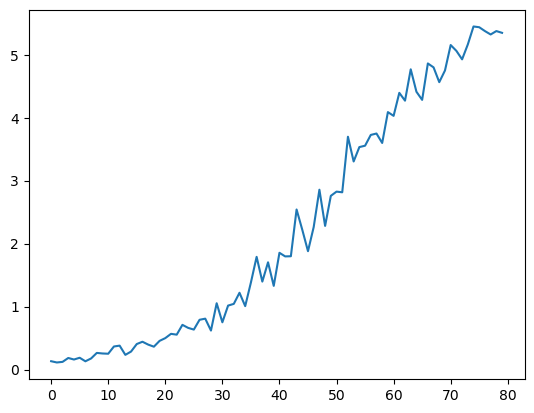

In [5]:
plt.plot(x)

In [6]:
import pymc as pm
import arviz as az

In [7]:
data = logistic_curve(T, t0, sigma, rho, L, k)

In [37]:
with pm.Model() as LogisticModel:
    pass

t_data = list(range(T))

LogisticModel.add_coord("obs_id", t_data, mutable=True)

with LogisticModel:
    # Priors for logistic curve parameters
    L = pm.Normal("L", mu=10, sigma=5)
    k = pm.HalfNormal("k", sigma=2)
    t0 = pm.Normal("t0", mu=50, sigma=10)

    # Priors for noise parameters
    rho = pm.Uniform("rho", lower=-1, upper=1)
    sigma = pm.HalfNormal("sigma", sigma=1)

    noise = pm.AR("noise", rho=rho, dims="obs_id")
    logistic = L / (1 + pm.math.exp(-k * (np.arange(T) - t0) + sigma * noise))

    # Likelihood
    Y_obs = pm.Normal("Y_obs", mu=logistic, sigma=0.1, observed=data)
    idata = pm.sample(2000, random_seed=100, target_accept=0.95)

    # idata.extend(pm.sample(2000, random_seed=100, target_accept=0.95))
    idata.extend(pm.sample_posterior_predictive(idata))

/Users/jmoran/anaconda3/envs/montecarlo/lib/python3.12/site-packages/pymc/model/core.py:999: FutureWarning: Coords are now always mutable. Specifying `mutable` will raise an error in a future release
  warnings.warn(
/Users/jmoran/anaconda3/envs/montecarlo/lib/python3.12/site-packages/pymc/distributions/timeseries.py:621: UserWarning: Initial distribution not specified, defaulting to `Normal.dist(0, 100, shape=...)`. You can specify an init_dist manually to suppress this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [L, k, t0, rho, sigma, noise]


/Users/jmoran/anaconda3/envs/montecarlo/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 26 seconds.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [Y_obs]


/Users/jmoran/anaconda3/envs/montecarlo/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

array([[<Axes: title={'center': 'L'}>,
        <Axes: title={'center': 'L'}, xlabel='Rank (all chains)'>],
       [<Axes: title={'center': 'k'}>,
        <Axes: title={'center': 'k'}, xlabel='Rank (all chains)'>],
       [<Axes: title={'center': 'noise'}>,
        <Axes: title={'center': 'noise'}, xlabel='Rank (all chains)'>],
       [<Axes: title={'center': 'rho'}>,
        <Axes: title={'center': 'rho'}, xlabel='Rank (all chains)'>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}, xlabel='Rank (all chains)'>],
       [<Axes: title={'center': 't0'}>,
        <Axes: title={'center': 't0'}, xlabel='Rank (all chains)'>]],
      dtype=object)

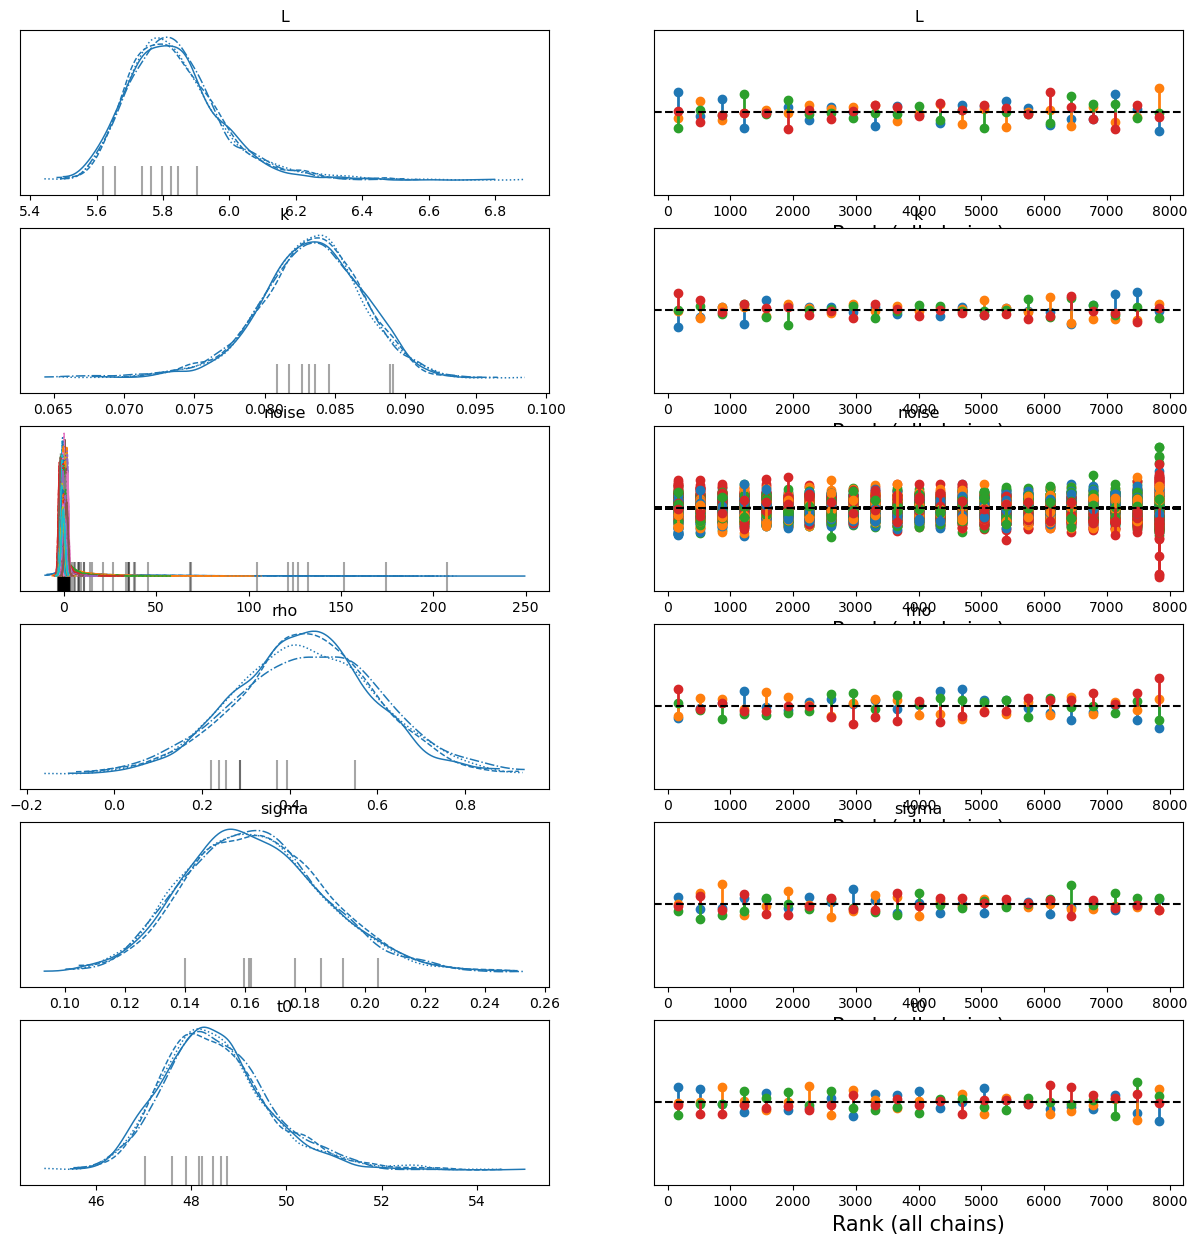

In [38]:
az.plot_trace(idata, figsize=(15, 15), kind="rank_vlines")

In [ ]:
idata

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

In [39]:
with LogisticModel:
    samples = pm.sampling.sample_posterior_predictive(idata)

Sampling: [Y_obs]


/Users/jmoran/anaconda3/envs/montecarlo/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

In [40]:
def generate_time_series_from_posterior(posterior_samples, t):
    # Number of samples to generate
    num_samples = posterior_samples.dims["chain"] * posterior_samples.dims["draw"]

    # Extract the posterior samples
    L_samples = posterior_samples["L"].values.flatten()
    k_samples = posterior_samples["k"].values.flatten()
    t0_samples = posterior_samples["t0"].values.flatten()
    rho_samples = posterior_samples["rho"].values.flatten()
    sigma_samples = posterior_samples["sigma"].values.flatten()

    generated_series = []

    for i in range(num_samples):
        generated_series.append(
            logistic_curve(
                t,
                t0_samples[i],
                sigma_samples[i],
                rho_samples[i],
                L_samples[i],
                k_samples[i],
            )
        )

    return np.array(generated_series)

In [62]:
def generate_time_series_from_posterior_noise(posterior_samples, t):
    # Number of samples to generate
    num_samples = posterior_samples.dims["chain"] * posterior_samples.dims["draw"]

    # Extract the posterior samples
    L_samples = posterior_samples["L"].values.flatten()
    k_samples = posterior_samples["k"].values.flatten()
    t0_samples = posterior_samples["t0"].values.flatten()
    rho_samples = posterior_samples["rho"].values.flatten()
    sigma_samples = posterior_samples["sigma"].values.flatten()
    noise = posterior_samples["noise"].values.reshape(8000, T)

    generated_series = []

    def logistic_curve_noise(t, t0, sigma, rho, L, k, noise):
        x = np.zeros(t)
        for i in range(t):
            x[i] = L / (1 + np.exp(-k * (i - t0) + sigma * noise[i]))
        return x

    for i in range(num_samples):
        generated_series.append(
            logistic_curve_noise(
                t,
                t0_samples[i],
                sigma_samples[i],
                rho_samples[i],
                L_samples[i],
                k_samples[i],
                noise[i],
            )
        )

    return np.array(generated_series)

In [63]:
idata.posterior["L"].values.shape

(4, 2000)

In [64]:
ts = generate_time_series_from_posterior_noise(idata.posterior, T)

/var/folders/0g/js2jbpxx5mj6tjfqgs45s6jr0000gn/T/ipykernel_63077/1476063076.py:3: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  num_samples = posterior_samples.dims["chain"] * posterior_samples.dims["draw"]


In [65]:
T

80

In [66]:
np.percentile(ts, [2.5, 97.5], axis=0).shape

(2, 80)

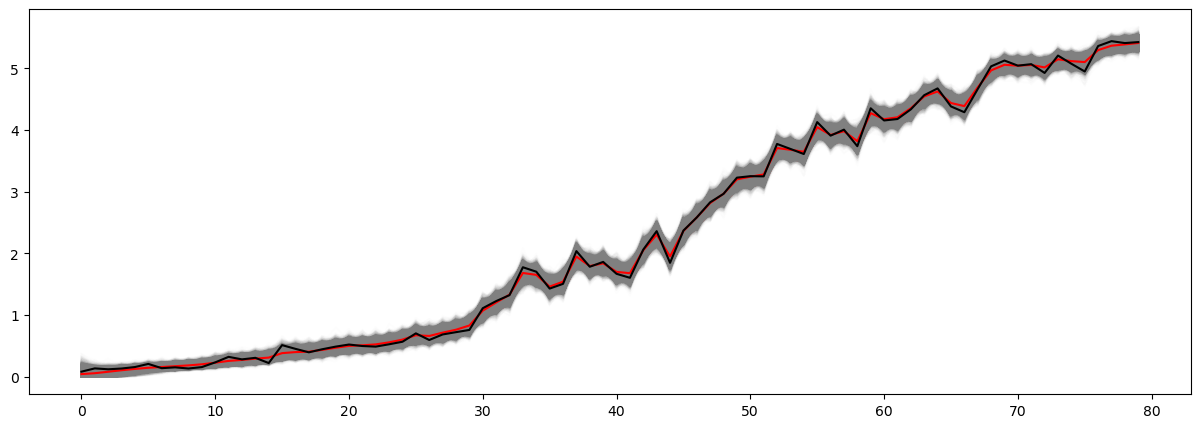

In [67]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
for i in range(ts.shape[0]):
    ax.plot(ts[i], color="gray", alpha=0.01)

# yerr is the 95% credible interval
yerr = np.percentile(ts, [5, 95], axis=0)


# add a line for the mean
ax.plot(np.mean(ts, axis=0), color="red", label="Mean")

# shaded area for the 95% credible interval
ax.fill_between(range(T), yerr[0], yerr[1], color="red", alpha=0.3, label="95% CI")

ax.plot(data, color="black", label="Observed data")
plt.show()

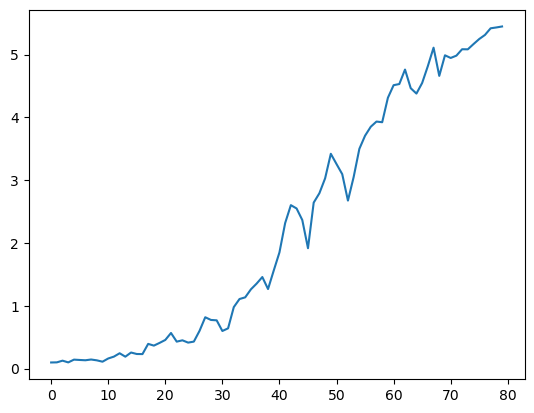

In [47]:
plt.plot(ts[2])

In [49]:
print(LogisticModel)

AttributeError: 'Dataset' object has no attribute 'Y_obs'

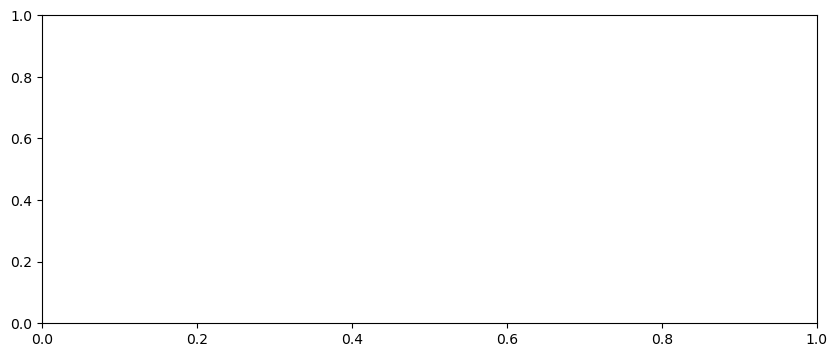

In [65]:
fig, ax = plt.subplots(figsize=(10, 4))
idata.posterior.Y_obs.mean(["chain", "draw"]).plot(
    ax=ax, label="Posterior Mean AR level"
)
ax.plot(data, "o", color="black", markersize=2, label="Observed Data")
ax.legend()
ax.set_title("Fitted AR process\nand observed data")

In [33]:
with pm.Model() as model:
    # Priors for logistic curve parameters
    L = pm.Normal("L", mu=10, sigma=5)
    k = pm.HalfNormal("k", sigma=2)
    t0 = pm.Normal("t0", mu=50, sigma=10)

    # Priors for noise parameters
    rho = pm.Uniform("rho", lower=-1, upper=1)
    sigma = pm.HalfNormal("sigma", sigma=1)

    # Model for the time series
    noise = pm.AR("noise", rho=rho, shape=T)
    logistic = L / (1 + pm.math.exp(-k * (np.arange(T) - t0) + noise))

    # Likelihood
    Y_obs = pm.Normal("Y_obs", mu=logistic, sigma=0.1, observed=data)

    # Sampling
    idata = pm.sample(draws=1000, tune=500, chains=2, target_accept=0.999)

/Users/jmoran/anaconda3/envs/montecarlo/lib/python3.12/site-packages/pymc/distributions/timeseries.py:621: UserWarning: Initial distribution not specified, defaulting to `Normal.dist(0, 100, shape=...)`. You can specify an init_dist manually to suppress this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [L, k, t0, rho, sigma, noise]


/Users/jmoran/anaconda3/envs/montecarlo/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 51 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
L,3.983,0.014,3.959,4.008,0.001,0.000,617.0,1269.0,1.00
k,0.115,0.009,0.100,0.132,0.001,0.001,150.0,134.0,1.01
rho,0.326,0.187,-0.006,0.657,0.021,0.017,80.0,40.0,1.02
sigma,0.785,0.592,0.002,1.839,0.011,0.008,1591.0,763.0,1.00


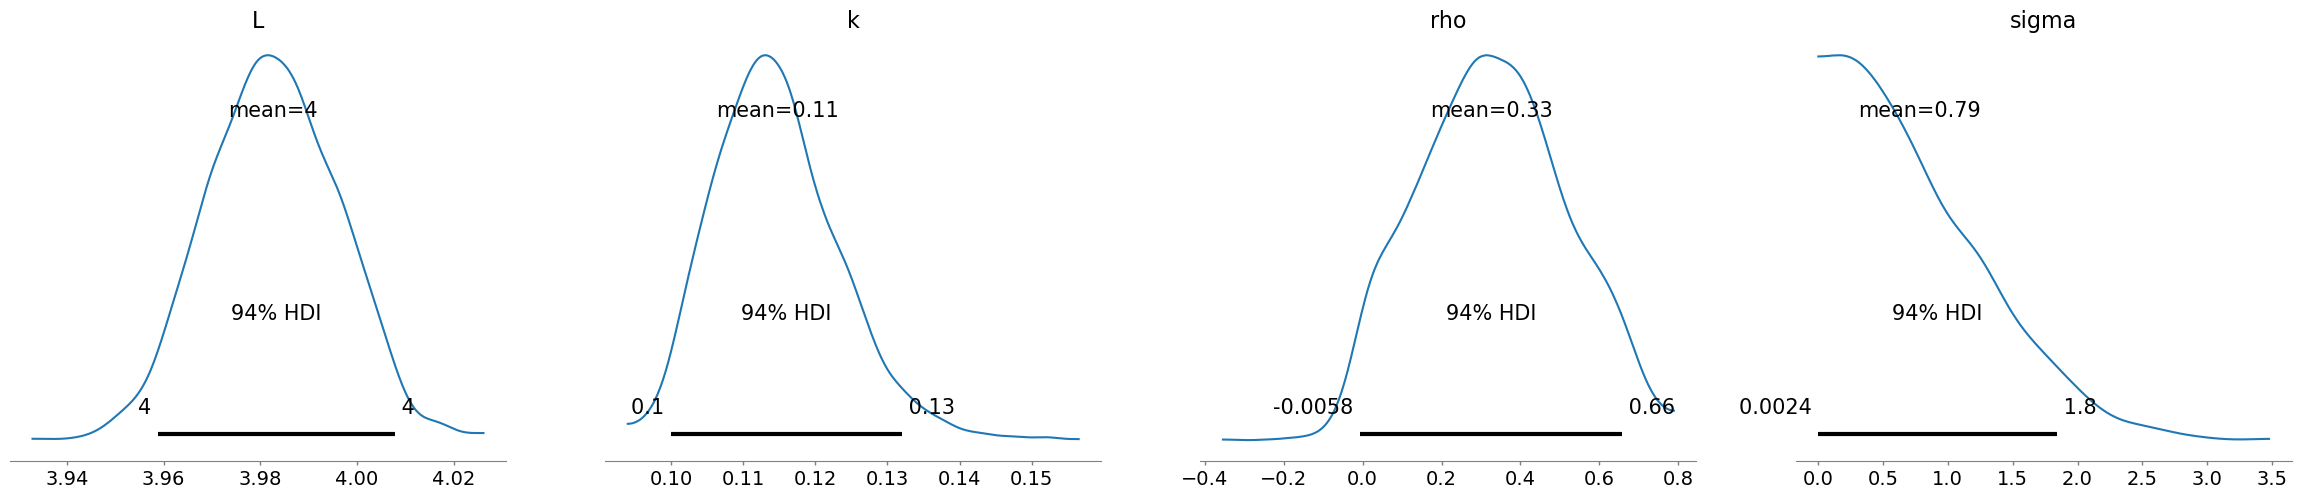

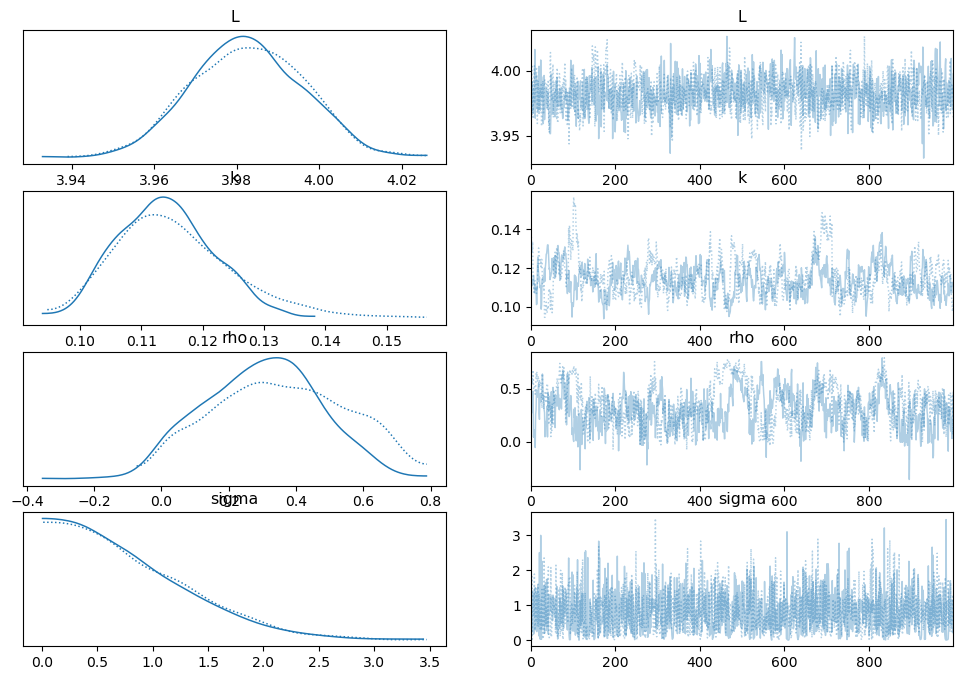

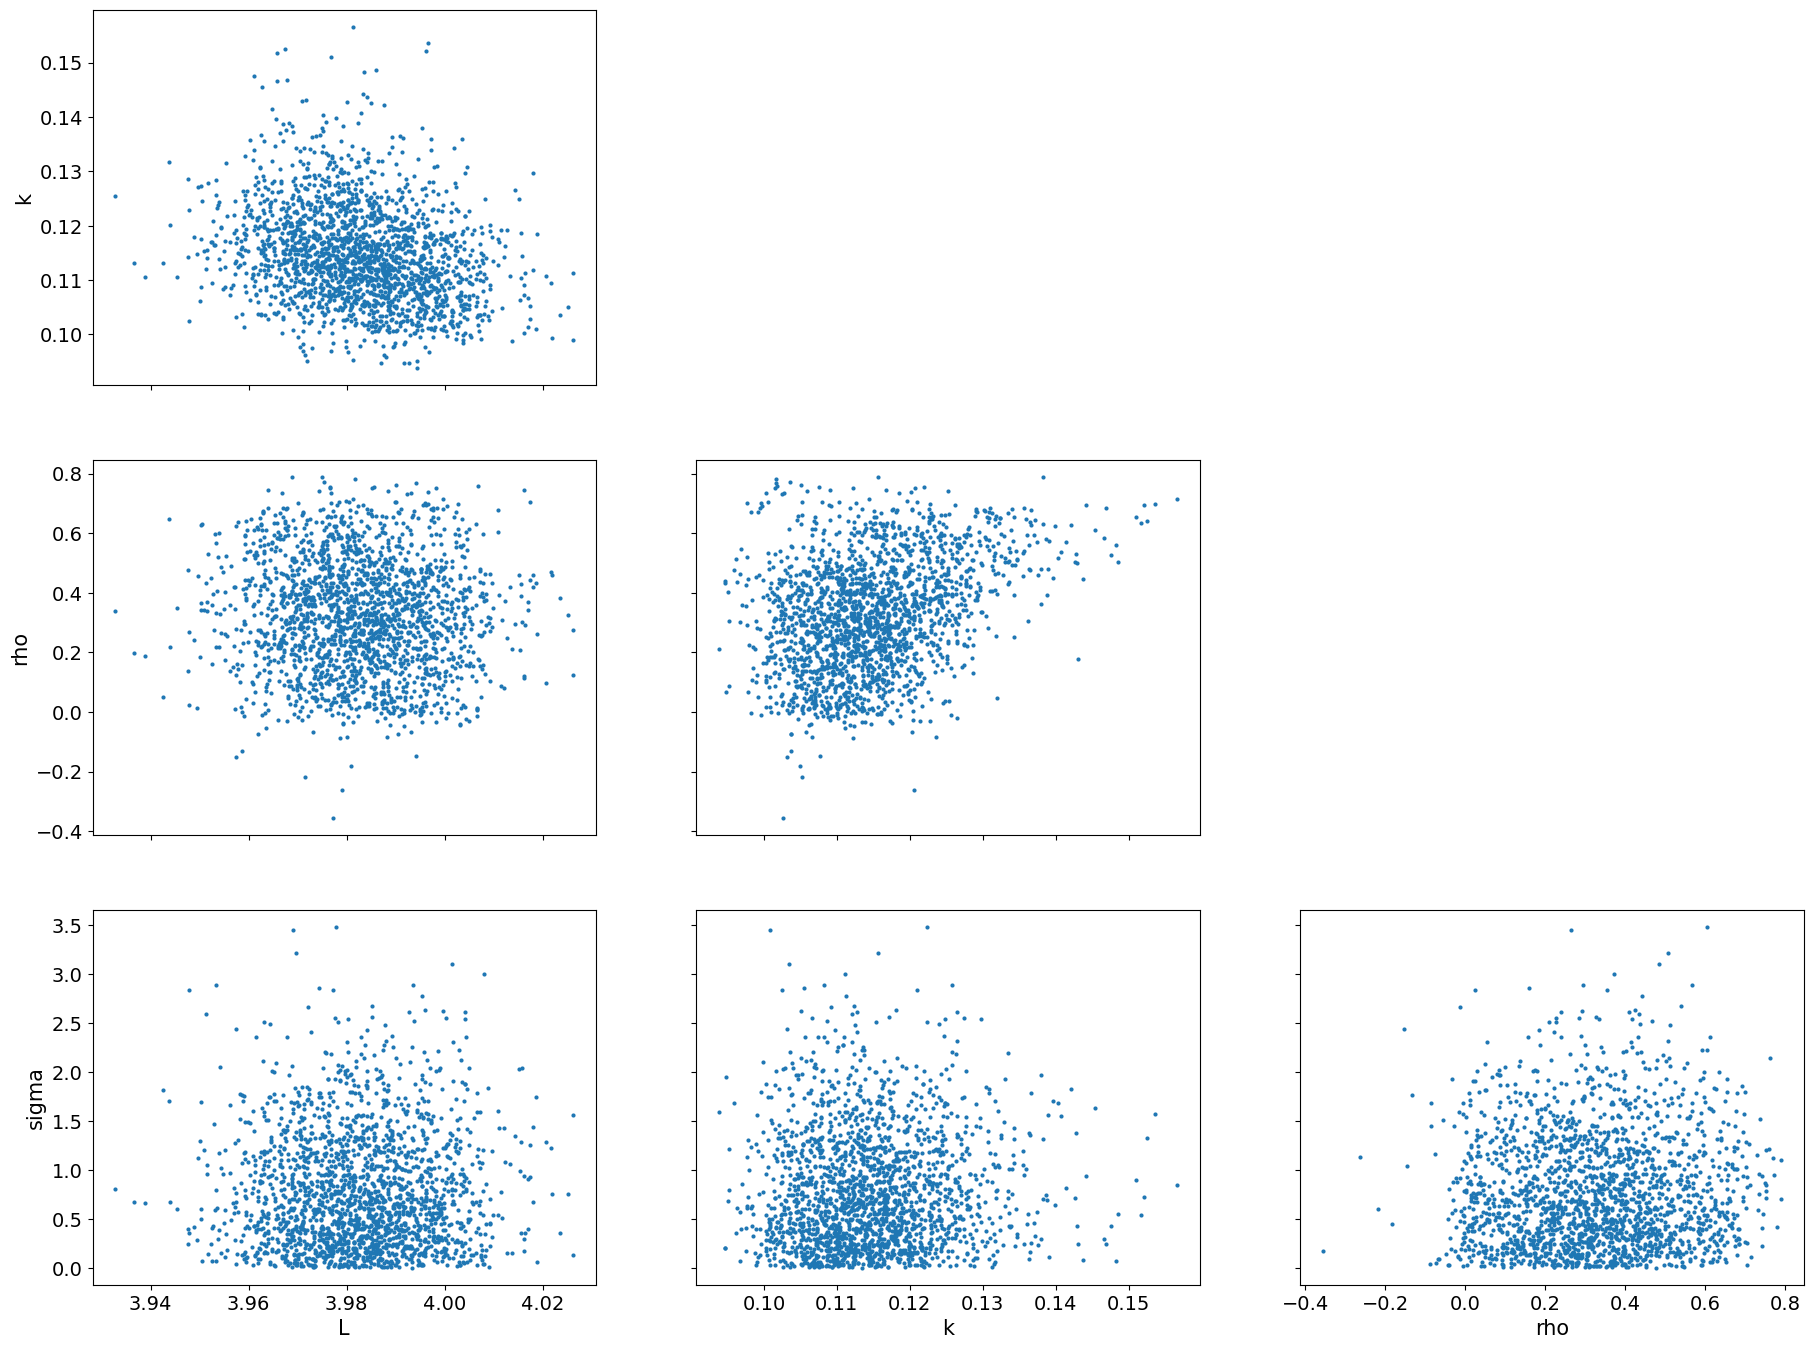

In [34]:
# Convert PyMC traces to ArviZ's InferenceData object

# Plotting posterior distributions
az.plot_posterior(idata, var_names=["L", "k", "rho", "sigma"])

# Generating a trace plot
az.plot_trace(idata, var_names=["L", "k", "rho", "sigma"])

# Creating a pair plot
az.plot_pair(idata, var_names=["L", "k", "rho", "sigma"])

# Model diagnostics
az.summary(idata, var_names=["L", "k", "rho", "sigma"])

In [37]:
idata

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

Sampling: [Y_obs]


/Users/jmoran/anaconda3/envs/montecarlo/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

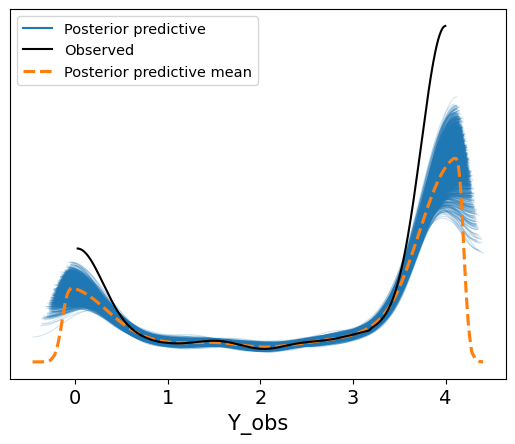

In [41]:
with model:
    idata.extend(pm.sample_posterior_predictive(idata))

az.plot_ppc(idata, data_pairs={"Y_obs": "Y_obs"})
plt.show()

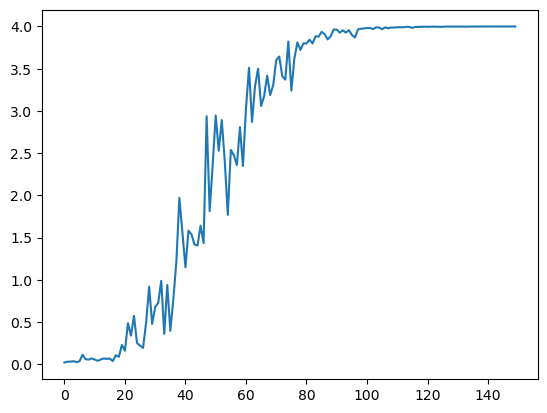

In [43]:
plt.plot(data)

In [44]:
idata

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data